In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score

np.set_printoptions(precision=2) # numpy prints all numbers up to 3rd decimals 

# Decision Trees Tutorial

### Classifying penguins
After working with the iris dataset a few times, let's move on to a more difficult task. We want to classify penguins with numerical properties like flipper length or body weight and with categorical properties like sex or home island.

This example nicely visualizes how the tree is built by piecewise classifications and highlights some key advantages of decision trees: 
- No scaling or normalization is required because the decision boundaries are piecewise for each feature in its own feature space.
- No filtering of important features is required here, because the algorithm doesn't use unimportant features. For larger data sets, however, pre-filtering is a good idea. 
- Decision trees can handle both numeric and categorical variables. 
- Decision trees are explanable and intuitive. 

In general, decision trees provide fast and good results. One reason for this is the underlying algorithm, which locally optimizes each branch of the decision process (greedy algorithm). In this way, a local minimum can be found quickly, but in most cases, a global optimum is not found. 

Therefore, the main negative aspect is robustness: Slight changes in the data can result in significantly different trees, and decision trees in general struggle with outliers or noise. The intuitive solution to this problem is to build multiple trees and classify a data point based on the classifications of the individual trees, as in a majority vote. Bagging (**B**ootstrap + **Agg**regat**ing**) generally aggregates the predictions of models. It is often used in the context of decision trees as *bagged trees* or as a famous variant *random forest*. Let's see, how this performs with our penguin data set.

At first,we load the data, remove missing entries and convert the categories into integer numbers:

  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
3          NaN     NaN  
4       3450.0  Female  
  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
4  Adelie  Torgersen            36.7           19.3              193.0   
5  Adelie  Torgersen            39.

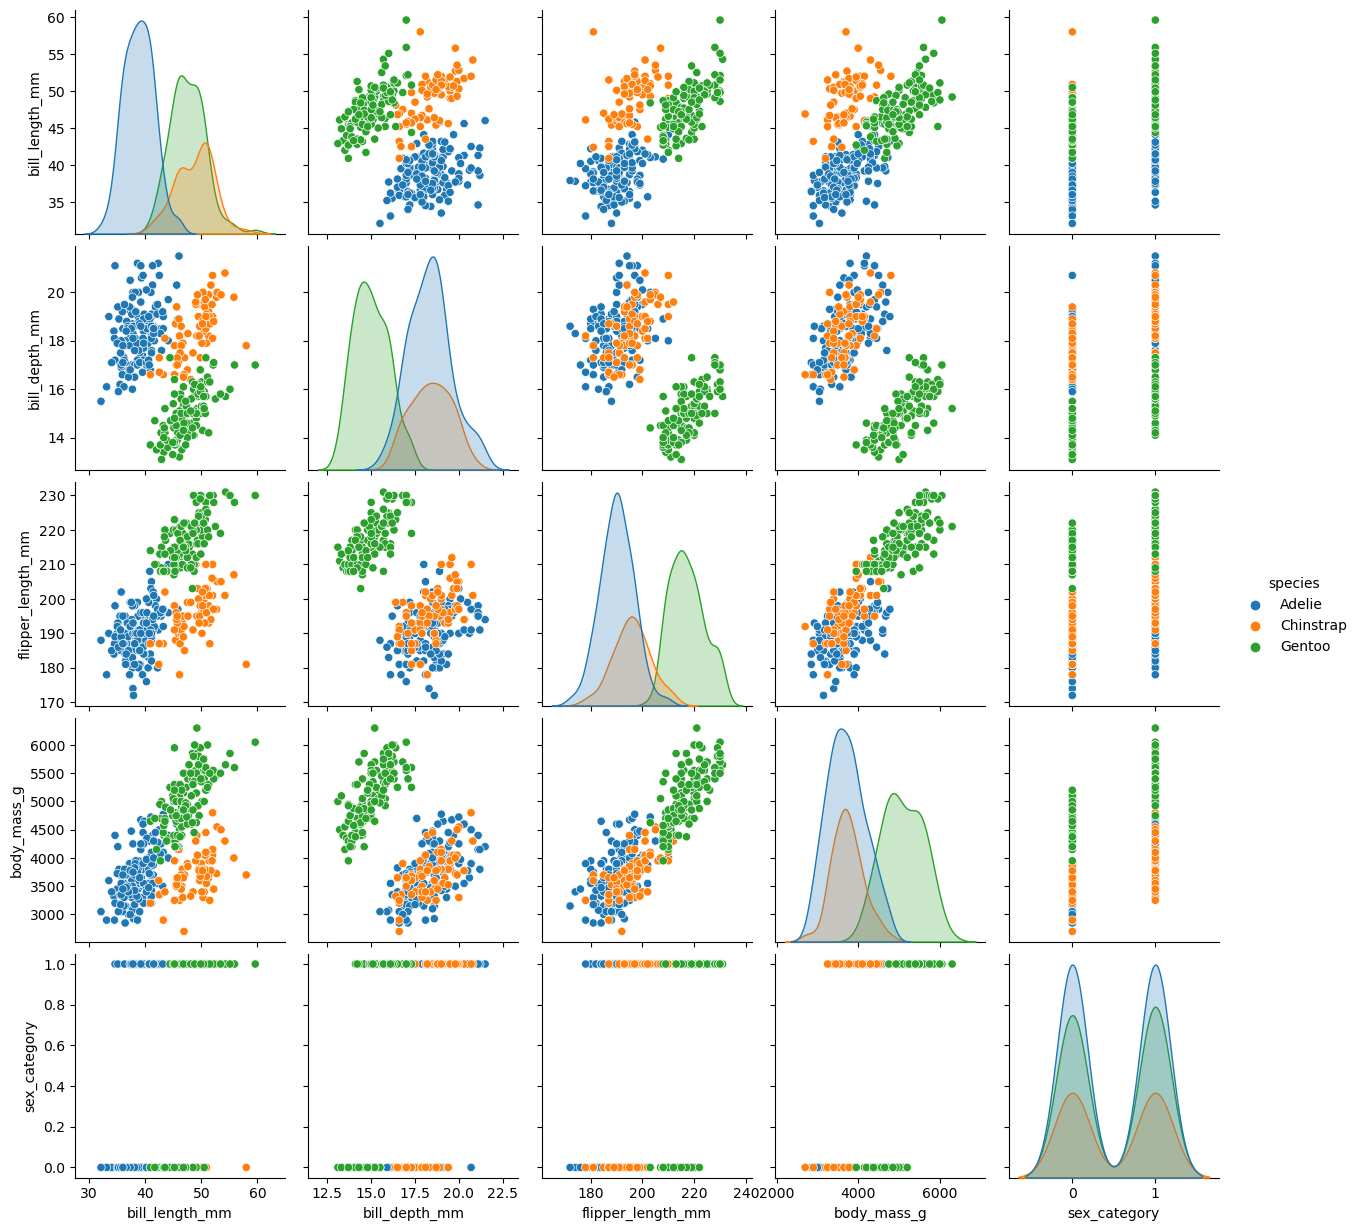

In [8]:
penguins: pd.DataFrame = sns.load_dataset("penguins")
print(penguins.head()) # you can see, that there are missing values and some categorical columns in the dataset
penguins.dropna(axis=0, inplace=True) # drop rows with missing values
numerical_column_list: list = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"] # list of numerical columns
categorical_column_list: list = ["species", "island", "sex"] # list of categorical columns
# convert categorical columns to numerical columns
for column in categorical_column_list:
    penguins[column] = penguins[column].astype("category")
    penguins[f"{column}_category"] = penguins[column].cat.codes # convert categorical to numerical columns
print(penguins.head()) # Nans are removed and categorical columns are converted to numerical columns
sns.pairplot(penguins, hue="species", vars=numerical_column_list+["sex_category"]) # pairplot of numerical columns and one categorical
plt.show()

From intuition and the pair plot, we expect that sex is not a good feature for classifying species. Bill depth and bill length seem to be much more descriptive.

We continue to define the features and labels, and shuffle and split the dataset:

In [3]:
features_list: list = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g", "sex_category", "island_category"] # list of features for the model
features: pd.DataFrame = penguins[features_list]
labels: pd.Series = penguins["species"]

X_train: np.ndarray
X_test: np.ndarray
y_train: np.ndarray
y_test: np.ndarray

# split the data into training and testing data, majority of the data is used for testing to see overfitting
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.9, random_state=42) 


We need to quantify the equality (impurity) of a group. During training, the impurity must be minimized, so that in the best case the impurity is zero, i.e. all leaf nodes have only one class. If $\omega_j$ is a label of class *j* and $P(\omega_j)$ is the proportion of samples of this class, a linear curve doesn't reflect the fact that the impurity rises quickly from proportion 100% (zero impurity) to proportion 80% (already significant impurity). The most commonly used metrics for impurity are

\begin{align*}
\text{Classification error:} & \quad i(n) = 1 - \max_j(P(\omega_j)) \\
\text{Entropy:} & \quad i(n) = -\sum_jP(\omega_j) \log_2 P(\omega_j) \\
\text{Gini impurity:} & \quad i(n) = 1 - \sum_jP(\omega_j)^2
\end{align*}

<img src="https://www.bogotobogo.com/python/scikit-learn/images/Entropy/ImpurityIndicesPlot.png" width="400" alt="impurity_metrics">

We will instantiate the decision tree with sklearn and define the commonly used gini metric as the criterion for training:




In [4]:
# max_depth: maximum depth of the tree
# criterion: function to measure the quality of a split
# max_features: number of features to consider when looking for the best split
model: tree.DecisionTreeClassifier = tree.DecisionTreeClassifier(max_depth=5, criterion="gini", max_features=0.5) # create a decision tree model
model.fit(X_train, y_train) # train the model

DecisionTreeClassifier(max_depth=5, max_features=0.5)

The decision tree object has a powerful method to visualize the tree: 

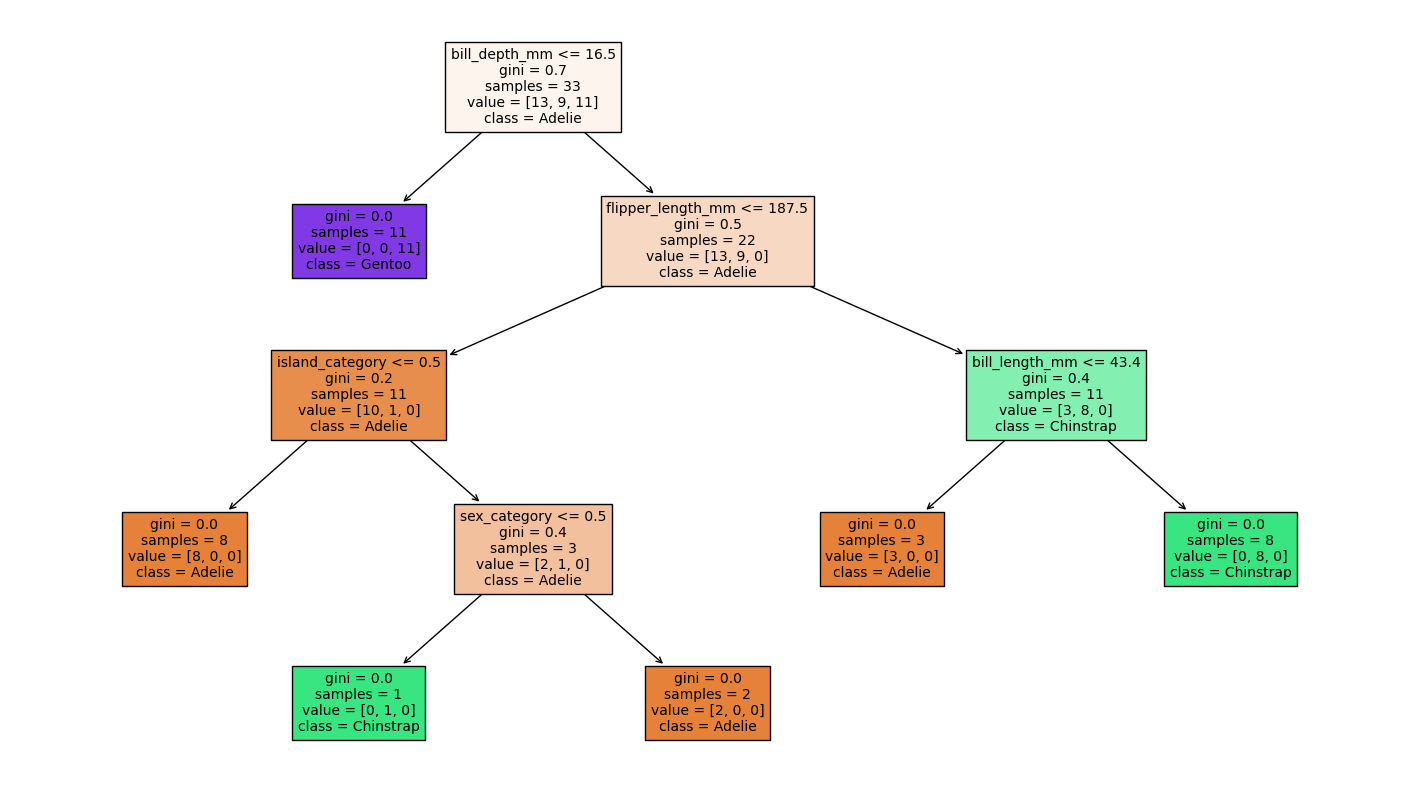

In [5]:
plt.figure(figsize=(18, 10))
tree.plot_tree(model, feature_names=features_list, class_names=model.classes_, filled=True, precision=1, fontsize=10) # plot the decision tree
plt.show()

Remember, that Decision tree make greedy decisions. This means, at each level, they will only look at the best decision boundrary to minimize the impurity RIGHT NOW and not in any future decision nodes.

With some randomness each run, we tend to fully split the dataset into pure leaf nodes (gini=0.0). Mostly physical features were used in the decision nodes. You can scroll up to the pair plot, to see whether it is a good decision. 

As in the previous classification exercises, we will use the test set to obtain quality metrices: 

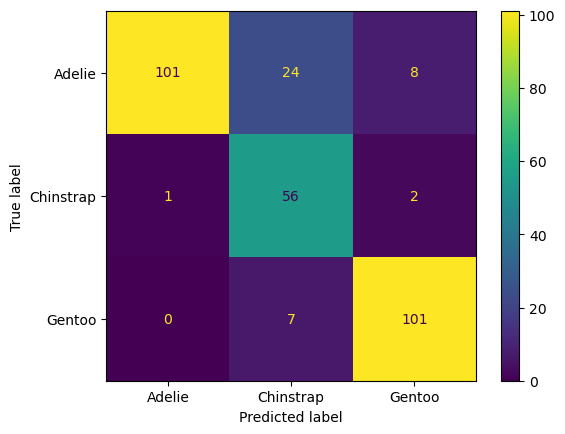

Accuracy: 0.86
Precision: 0.89
Recall: 0.86
F1-Score: 0.86
              precision    recall  f1-score   support

      Adelie       0.99      0.76      0.86       133
   Chinstrap       0.64      0.95      0.77        59
      Gentoo       0.91      0.94      0.92       108

    accuracy                           0.86       300
   macro avg       0.85      0.88      0.85       300
weighted avg       0.89      0.86      0.86       300



In [6]:
y_prediction: np.ndarray = model.predict(X_test) # predict the test data
cm: np.ndarray = confusion_matrix(y_test, y_prediction)
disp: ConfusionMatrixDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

accuracy: float = accuracy_score(y_test, y_prediction)
precision: float = precision_score(y_test, y_prediction, average='weighted')
recall: float = recall_score(y_test, y_prediction, average='weighted')
f1: float = f1_score(y_test, y_prediction, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

print(classification_report(y_test, y_prediction, target_names=model.classes_)) # Combine all the metrics in one table for each class


In the last step, we will use a random forest classifier to do the same job. As mentioned above, the idea is to create 100 trees, train each tree with a subsample of the training data (bootstrap samples), and classify each sample based on the 100 classifications in the 'forest'. This way, we should get a more robust, less overfitting classifyer. 

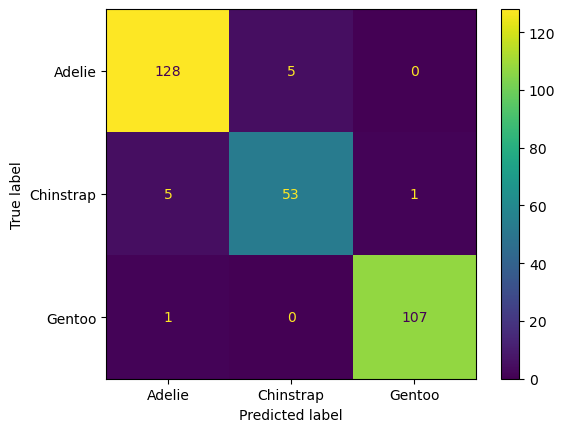

              precision    recall  f1-score   support

      Adelie       0.96      0.96      0.96       133
   Chinstrap       0.91      0.90      0.91        59
      Gentoo       0.99      0.99      0.99       108

    accuracy                           0.96       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.96      0.96      0.96       300



In [7]:
# n_estimators: number of trees in the forest
# max_depth: maximum depth of the tree
# criterion: function to measure the quality of a split
# bootstrap: whether bootstrap samples/bagged samples are used when building trees
# max_features: number of features to consider when looking for the best split
# max_samples: number of training data to use when building trees, here 90%. 
ensemble_model: RandomForestClassifier = RandomForestClassifier(n_estimators=100, max_depth=4, criterion="gini", bootstrap=True, max_samples=0.9, max_features=0.5) # create a random forest model
ensemble_model.fit(X_train, y_train) # train the model

y_prediction: np.ndarray = ensemble_model.predict(X_test) # predict the test data
cm: np.ndarray = confusion_matrix(y_test, y_prediction)
disp: ConfusionMatrixDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ensemble_model.classes_)
disp.plot()
plt.show()

print(classification_report(y_test, y_prediction, target_names=ensemble_model.classes_))

You'll notice, that the `RandomForest` Ensemble with bagging yields a generally better prediction from the same limited training set compared to the lone `DecisonTree`. 